In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np

## Summary: Edelweiss C and its Error

One wonders if a different estimate on the widening necessary for the nuclear-recoil band would happen if there were systematic errors on e.g. the recorded voltage on the detector.

This notebook examines the effect of possible systematics on C.

## Band Widths
Edelweiss parametrizes their band widths for all detectors (see eq'ns 9, 10, and 11 from the above paper).  

$$\sigma_{Q\gamma}(E_R) = \frac{1 + V/\epsilon}{E_R}\sqrt{\sigma_I^2 + \sigma_H^2}$$

$$\sigma_{Qn}(E_R) = \sqrt{C^2 + \frac{1}{E^2_R} \left( \left(1+\frac{V}{\epsilon}\langle Q_n\rangle\right)^2\sigma_I^2 + \left( 1+\frac{V}{\epsilon}\right)^2\langle Q_n\rangle^2\sigma_H^2\right)} $$

where $C$ is a fitted constant; $\epsilon$ is the average energy needed to create a single electron-hole pair in germanium (3 eV); and $\langle Q_n \rangle$, $\sigma_I^2$, and $\sigma_H^2$ are all functions of the true recoil energy $E_R$. The yield $\langle Q_n \rangle = 0.16 E_R^{0.18}$.  The terms $\sigma_I^2$ and $\sigma_H^2$ should be read as "the heat/ionization resolution for an energy deposit of $E_R$."  For the electron recoil band and $\sigma_{Q\gamma}$, the arguments for$\sigma_I^2$ $\sigma_H^2$ are $E_R$ since for electron recoils, $E_I = E_R$ and $E_H = E_R$.  For nuclear recoils the heat and ionization energy are not identical to the energy $E_R$ and are defined in the section below.

In [2]:
import numpy as np
import pandas as pd
#from joblib import Memory
import matplotlib.pyplot as plt
%matplotlib inline 
import h5py
from scipy import optimize
import lmfit as lmf
#import emcee

import sys
sys.path.append('../python/')
from EdwRes import *
from prob_dist import *

GGA3/NR/4.0/5.556E-02/0.0380/000/0.1493/0.1782/0.9975/
GGA3/NR/4.0/5.556E-02/0.0381/000/0.1537/0.1703/0.9948/


In [3]:


# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
aH = 0.0157
pars = {
    'V' : 4.0,
    'eps_eV' : 3.0
    }



In [4]:
from edelweiss_fit import *

# import data from Edelweiss
resNR_data = pd.read_csv("data/edelweiss_NRwidth_GGA3_data.txt", skiprows=1, \
                       names=['E_recoil', 'sig_NR', 'E_recoil_err', 'sig_NR_err'], \
                       delim_whitespace=True)

resER_data = pd.read_csv("data/edelweiss_ERwidth_GGA3_data.txt", skiprows=1, \
                         names=['E_recoil', 'sig_ER', 'sig_ER_err'], \
                         delim_whitespace=True)

# the sorting is necessary!
# otherwise the mask defined below will select the wrong data
resER_data = resER_data.sort_values(by='E_recoil')

#print (res_data.head(4))

# set the data up for the fits
# Edelweiss discards ER points near peaks
# and first two NR points since they're affected by the threshold
mask = [True, True, False, False, True, True, True, True, True]
ER_data = {'Erecoil': resER_data["E_recoil"][mask], 'sigma': resER_data["sig_ER"][mask], 'sigma_err': resER_data["sig_ER_err"][mask]}
NR_data = {'Erecoil': resNR_data["E_recoil"][2::], 'sigma': resNR_data["sig_NR"][2::], 'sigma_err': resNR_data["sig_NR_err"][2::]}

## Fit with an MCMC method

## Find the minimum likelihood

When all six parameters are allowed to vary, the solution finds a small value for A and a larger value for B:

aH, C, m, scale, A, B = array([1.59557510e-02, 4.01120006e-02, 4.11442471e-05, 1.03493435e+00, 1.16847345e-01, 1.52032678e-01])

### Global minimization results
Brute: sadly this does not complete in a reasonable time (less than a day)

Basinhopping: does not successfully converge on a solution

SHGO: overflows occur in the yeild function but it still reports converging successfully with a function value of -53.623 and solution of xl: array([[1.59555935e-02, 4.01182258e-02, 4.10754863e-05, 1.03491851e+00,
        1.16818488e-01, 1.51974313e-01]]).


In [5]:
import h5py

#get Edw fit results for sampling 6 parameters
filename = 'data/systematic_error_fits_corr_corrAB.h5'
filename = 'data/systematic_error_fits.h5'
#remove vars
f = h5py.File(filename,'r')
#for i in f['mcmc/edwdata_sys_error']:
#    print(i)

#save the results for the Edw fit
path='{}/{}/'.format('mcmc','edwdata_sys_error')

Cms = np.asarray(f[path+'Cms'])
slope = np.asarray(f[path+'m'])
a_yield = np.asarray(f[path+'A'])
b_yield = np.asarray(f[path+'B'])
aH = np.asarray(f[path+'aH'])
scale = np.asarray(f[path+'scale'])
samples = np.asarray(f[path+'samples'])
sampsize = np.asarray(f[path+'sampsize'])
xl = np.asarray(f[path+'Er'])
upvec = np.asarray(f[path+'Csig_u'])
dnvec = np.asarray(f[path+'Csig_l'])
Sigtot = np.asarray(f[path+'Sigss'])
Sigss = np.sqrt(Sigtot**2 - (Cms+slope*xl)**2)

#print(Cms)
#print(samples[0:5,:])
f.close()
#print(np.shape(samples))
print("Cms: {}".format(Cms))
print("m: {}".format(slope))
print("A: {}".format(a_yield))
print("B: {}".format(b_yield))
print("aH: {}".format(aH))
print("eta: {}".format(scale))

Cms: 0.0401182258
m: 4.10754863e-05
A: 0.116818488
B: 0.151974313
aH: 0.0159555935
eta: 1.03491851


In [6]:
# plot the best fit


# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
par_dict = {'V' : scale*4.0,'eps_eV' : 3.0, 'a': a_yield, 'b': b_yield}

ref_sigER_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                par_dict, aH)
    
ref_sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                  par_dict, aH, Cms, slope)

# Only the systematic error

The above calculation includes both the statistical error (from the uncertainty on the data points) and the systematic error (from the uncertainty on parameters used in the fit like the voltage across the detector and the yield model).

In the interest of understanding how future analyses might improve on an estimate of the NR Fano, we examine the uncertainty introduced by the systematic error alone.

The statistical error is drawn from stat_uncertainty_C.ipynb.

In [7]:
# get the data mcmc_fits.h5 from stat_uncertainty_C.ipynb
filename_stat_error = 'data/mcmc_fits.h5'
f = h5py.File(filename_stat_error,'r')

path='{}/{}/'.format('mcmc','edwdata')

exCms = np.asarray(f[path+'Cms'])
exslope = np.asarray(f[path+'m'])
exEr = np.asarray(f[path+'Er'])
exCsig_u = np.asarray(f[path+'Csig_u'])
exCsig_l = np.asarray(f[path+'Csig_l'])
exSigss = np.asarray(f[path+'Sigss'])
exsamples = np.asarray(f[path+'samples'])

#save the results for the Edw fit
path='{}/{}/'.format('mcmc','multiples')

Cms_m = np.asarray(f[path+'Cms'])
slope_m = np.asarray(f[path+'m'])
samples_m = np.asarray(f[path+'samples'])
sampsize_m = np.asarray(f[path+'sampsize'])
xl_m = np.asarray(f[path+'Er'])
upvec_m = np.asarray(f[path+'Csig_u'])
dnvec_m = np.asarray(f[path+'Csig_l'])
Sigss_m = np.asarray(f[path+'Sigss'])

f.close()
print(np.shape(samples_m))

f.close()

print (np.shape(exEr))

(40000, 2)
(500,)


In [8]:
#get the NR calculations for our yield band
import fano_calc as fc
Enr,signr = fc.RWCalc(filename='data/res_calc.h5',band='NR',alpha=(1/18.0))

#let's make a callable out of the predicted single-scatter resolution
import scipy.interpolate as inter

sigQnr_c = inter.InterpolatedUnivariateSpline(Enr, signr, k=3)
sigQnr_c_v = np.vectorize(sigQnr_c)
sigQnr = np.sqrt(sigQnr_c_v(exEr)**2+(exCms+exslope*exEr)**2)

GGA3/NR/4.0/5.556E-02/0.0381/000/


<ErrorbarContainer object of 3 artists>

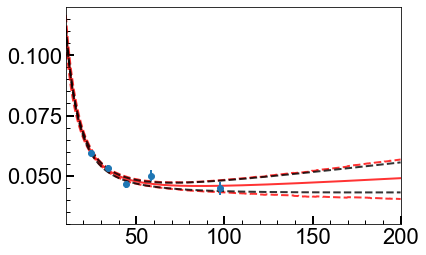

In [9]:
Erecoil_keV = np.linspace(10, 200, 500)

plt.plot(xl, ref_sigNR_func(xl), color="r", lw=2, alpha=0.8)
plt.plot(xl, upvec, color="r",linestyle="--", lw=2, alpha=0.8)
plt.plot(xl, dnvec, color="r",linestyle="--", lw=2, alpha=0.8)

# the best-fit is different for the two-parameter (C and m) fit
# than for the six-parameter fit

#plt.plot(exEr, ref_sigNR_func(exEr), color='k', lw=2, alpha=0.8)
a = ref_sigNR_func(exEr) + exCsig_u - sigQnr
b = ref_sigNR_func(exEr) - (-exCsig_l + sigQnr)
plt.plot(exEr, a, color="k",linestyle="--", lw=2, alpha=0.8)
plt.plot(exEr, b, color="k",linestyle="--", lw=2, alpha=0.8)

plt.xlim(10, 200)
plt.ylim(0.03,0.12)
plt.errorbar(NR_data['Erecoil'], NR_data['sigma'], yerr=NR_data['sigma_err'], fmt="o", label="data", capsize=0)

In [10]:
import fano_extract as fe

#get the samples for stat only errors
#get one sigma errors

print(np.shape(exsamples))
print(exsamples[0])
#get the energy vector
Evec = np.linspace(7.0,200,10)
   
sampsize=1000
exFi = np.zeros((np.shape(Evec)[0],sampsize))
i=0
for Cms_em, m_em in exsamples[np.random.randint(len(exsamples), size=sampsize)]:
    msfit=samples_m[np.random.randint(len(samples_m), size=1)]
    msfit = np.asarray(msfit[0])   
    fit = np.asarray([aH, Cms_em, m_em, scale, a_yield, b_yield])
    Fano= fe.get_root_from_sigvec(Evec,fit,msfit)
    exFi[:,i] = Fano
    i=i+1
    #ax1.plot(Evec, Fi, color="blue", alpha=0.05)
    
exupvec = np.mean(exFi,axis=1)+np.std(exFi,axis=1)
exdnvec = np.mean(exFi,axis=1)-np.std(exFi,axis=1)

(40000, 2)
[3.38076602e-02 7.46558830e-05]


In [ ]:
#extract for sys errors all

sampsize=1000
sysFi = np.zeros((np.shape(Evec)[0],sampsize))
print(np.shape(samples))
print(samples[0])
i=0
for aH_em, Cms_em, m_em, scale_em, A_em, B_em in samples[np.random.randint(len(samples), size=sampsize)]:
    msfit=samples_m[np.random.randint(len(samples_m), size=1)]
    msfit = np.asarray(msfit[0])   
    fit = np.asarray([aH_em, Cms_em, m_em, scale_em, A_em, B_em])
    Fano= fe.get_root_from_sigvec(Evec,fit,msfit)
    sysFi[:,i] = Fano
    i=i+1
    #ax1.plot(Evec, Fi, color="blue", alpha=0.05)
    
sysupvec = np.mean(sysFi,axis=1)+np.std(sysFi,axis=1)
sysdnvec = np.mean(sysFi,axis=1)-np.std(sysFi,axis=1)

(470000, 6)
[1.65991113e-02 3.17938117e-02 1.72848169e-04 9.60623060e-01
 2.53571472e-01 3.89854952e-02]


[ 55.3846781  153.17819152 236.22227753 306.78464521 368.38803969
 424.46967355 478.68252799 534.91066453          nan          nan]
[ -2.04974073   2.31209249  13.81218167  31.46568123  53.68265238
  78.48260268 103.37087668 125.4027778           nan          nan]
[ 11.37154958  38.03980502  72.9072985  122.84226838 189.81557128
 274.90834961 379.68569702 505.83165237 655.04477512 829.00912485]
[  7.25506088  30.06929006  61.37733872  96.26467835 134.96716156
 178.57808229 227.70660977 282.80980112 344.28309448 412.48695193]


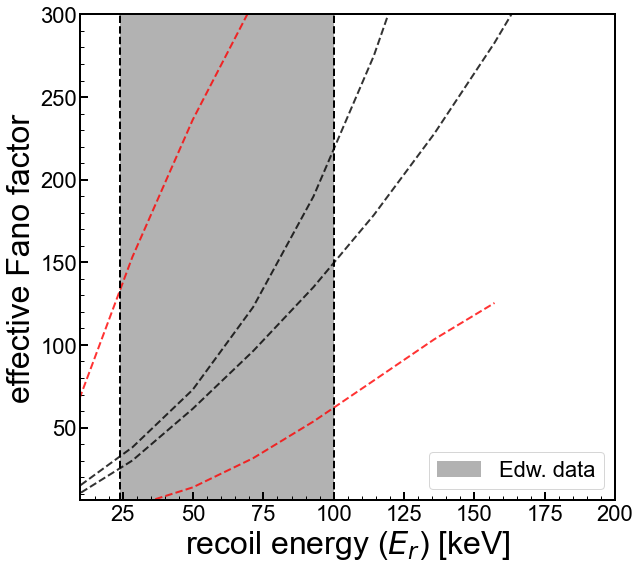

In [15]:
#set up a plot
print(sysupvec)
print(sysdnvec)
print(exupvec)
print(exdnvec)

fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

xmax=10

blue = '#118DFA'

#i=0
#for aH_em, Cms_em, m_em, scale_em, A_em, B_em in samples[np.random.randint(len(samples), size=sampsize)]:
    #msfit=samples_m[np.random.randint(len(samples_m), size=1)]
    #msfit = np.asarray(msfit[0])   
    #fit = np.asarray([aH_em, Cms_em, m_em, scale_em, A_em, B_em])
    #Fi= fe.get_root_from_sigvec(Evec,fit,msfit)
#    ax1.plot(Evec, Fi[:,i], color="blue", alpha=0.05)
#    i=i+1

ax1.plot(Evec, sysupvec, color="r",linestyle="--", lw=2, alpha=0.8)
ax1.plot(Evec, sysdnvec, color="r",linestyle="--", lw=2, alpha=0.8)
ax1.plot(Evec, exupvec, color="k",linestyle="--", lw=2, alpha=0.8)
ax1.plot(Evec, exdnvec, color="k",linestyle="--", lw=2, alpha=0.8)
    
#ax1.plot (X, diff, 'm-', label='Thomas-Fermi (newgrad)')
#ax1.plot (Esi(epr), 100*np.sqrt(f_Omega2_eta2(epr))*ylindv(1000*Esi(epr)), 'g-', label='$\Omega/\epsilon$ (NAC III approx. D)')
#ax1.plot (Evec, Fcentral, 'k-', label='extracted Ge eff. Fano')
#ax1.plot (Er, Fup, 'b', label='')
#ax1.plot (Er, Fdn, 'b', label='')



#ax1.fill_between(Evec,upvec,dnvec,facecolor='m',alpha=0.5,label='1$\sigma$ statistical region')
plt.axvline(x=24.0,color='k',linestyle="--")
plt.axvline(x=100,color='k',linestyle="--")
ax1.fill_between([24.0,100.0],[6,6],[300,300],facecolor='k',alpha=0.3,label='Edw. data')


ax1.set_yscale('linear')
ax1.set_xscale('linear')
ax1.set_xlim(10, 200)
ax1.set_ylim(6,300)
ax1.set_xlabel('recoil energy ($E_r$) [keV]')
ax1.set_ylabel('effective Fano factor')
#ax1.grid(True)
#ax1.xaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()